<a href="https://colab.research.google.com/github/gabrielborja/machine_learning/blob/main/space_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classification of space rocks

##Uploading packages

In [ ]:
#Importing necessary libraries
#Data manipulation and visualization
import numpy as np
import matplotlib.pyplot as plt

#Deep learning and AI models
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

#Process, crop and resize images
import torchvision
from torchvision import datasets, transforms, models

#Visualize images
from PIL import Image

In [ ]:
#Showing images in High resolution
%config InlineBackend.figure_format = 'retina'

In [ ]:
#Uploading file from local drive
from google.colab import files
uploaded1 = files.upload()

Saving Data.zip to Data.zip


In [ ]:
#Storing images in file
import zipfile
import io

data_1 = zipfile.ZipFile(io.BytesIO(uploaded1['Data.zip']), 'r')
data_1.extractall() #==> Extracting all from zip to file directory

In [ ]:
#Checking images in file directory
#!unzip file_location
#data_1.printdir()

##Data Cleaning

In [ ]:
# Creating a function to load the data, crop and resize the images, split data into two groups: test and train
def load_split_train_test(data_dir, valid_size = .2):

    # Transforming the images to train the model
    train_transforms = transforms.Compose([
                                       transforms.RandomResizedCrop(224),
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])

    # Transforming the images to test the model
    test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                          transforms.Resize(224),
                                          transforms.ToTensor(),
                                      ])

    # Creating two variables for the folders with the training and testing images
    train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=test_transforms)

    # Getting the number of images in the training folder
    num_train = len(train_data)

    # Creating a list of numbers from 0 to the number of training images - 1
    indices = list(range(num_train))

    # If valid_size is .2, find the index of the image that represents 20% of the data
    # If there are 10 images, a split would result in 2
    # split = int(np.floor(.2 * 10)) -> int(np.floor(2)) -> int(2) -> 2
    split = int(np.floor(valid_size * num_train))

    # Randomly shuffle the indices
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler

    # Creating randomly shuffled indices
    train_idx, test_idx = indices[split:], indices[:split]

    # Creating samplers to randomly grabbing items from the training and testing indices lists
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # Creating loaders to load 16 images from the train and test data folders
    # Images are chosen based on the shuffled index lists and by using the samplers
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    # Return the loaders so you can grab images randomly from the training and testing data folders
    return trainloader, testloader

In [ ]:
# Using the function that shuffles images,
# creating a trainloader to load 20% of the images
# creating a testloader to load 80% of the images
data_dir = './Data'
trainloader, testloader = load_split_train_test(data_dir, .2)

# Printing the type of rocks that are included in the trainloader
print(trainloader.dataset.classes)

['Basalt', 'Highland']


In [ ]:
# Transforming an image into pixels and resizing it
test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])

# Randomly selecting a set of images
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    # Creating an iterator to iterate over the shuffled images in the test image dataset
    dataiter = iter(loader)

    # Getting the images and labels from the iterator
    images, labels = dataiter.next()
    
    return images, labels

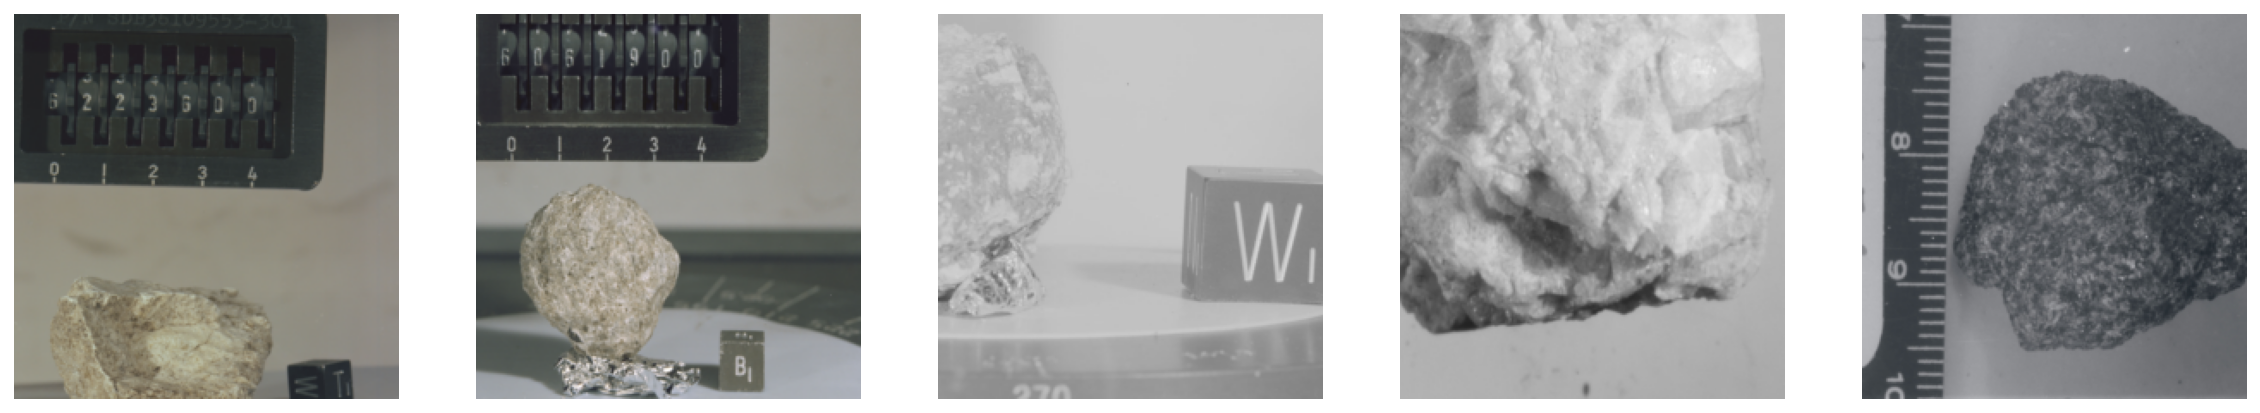

In [ ]:
# Showing five random images
images, labels = get_random_images(5)

# Converting the array of pixels to an image
to_pil = transforms.ToPILImage()
fig=plt.figure(figsize=(20,20))

# Getting a list of all classes in the training data
classes=trainloader.dataset.classes

# Drawing the images in a plot to display in the notebook
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)

# Displaying all of the images
plt.show()

In [ ]:
# Determining if a CPU or a GPU device is in use to build the deep learning network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

##Building a Neural Network

In [ ]:
# Building all the neurons
for param in model.parameters():
     param.requires_grad = False

# Wiring the neurons together to create the neural network
model.fc = nn.Sequential(nn.Linear(2048, 512),
                               nn.ReLU(),
                               nn.Dropout(0.2),
                               nn.Linear(512, 2),
                               nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# Adding the neural network to the device
model.to(device)

print('done')

done


In [ ]:
# Set the initial number of iterations to search for associations
epochs = 5
print_every = 5

# Initialize the loss variables
running_loss = 0
train_losses, test_losses = [], []

# Track the current training step, start at 0
steps = 0

# Search for associations in the features
for epoch in range(epochs):

   # Count each epoch
   epoch += 1

   # Load in all of the image inputs and labels from the TRAIN loader 
   for inputs, labels in trainloader:

      # Count each training step
      steps += 1
      print('Training step ', steps)

      # Load the inputs and labels to the already selected device
      inputs, labels = inputs.to(device), labels.to(device)

      # Zero out gradients to avoid accumulations of gradiants across training iterations
      optimizer.zero_grad()

      # Pass the images through the model, return the log probabilities of each label
      logps = model.forward(inputs)

      # Run the log probabilities through the criterion to get the output graph
      loss = criterion(logps, labels)

      # Use the loss graph to compute gradients
      loss.backward()

      # Update the parameters based on the current gradient
      optimizer.step()

      # Add the actual loss number to the running loss total
      running_loss += loss.item()

      # Every 5 steps, evaluate the model
      if steps % print_every == 0:

         # Initialize loss and accuracy
         test_loss = 0
         accuracy = 0

         # Start the model evaluation
         model.eval()

         # Refine the accuracy of the prediction without updating the gradients
         with torch.no_grad():

            # Load in all of the image inputs and labels from the TEST loader 
            for inputs, labels in testloader:

               # Load the inputs and labels to the already selected device
               inputs, labels = inputs.to(device), labels.to(device)

               # Pass the images through the model, return the log probabilities of each label
               logps = model.forward(inputs)

               # Run the log probabilities through the criterion to get the output graph
               batch_loss = criterion(logps, labels)

               # Add the actual loss number to the running loss total for the test batch
               test_loss += batch_loss.item()

               # Return a new tensor with the true probabilities
               ps = torch.exp(logps)

               # Return the largest probability and class of the new tensor along a given dimension
               top_p, top_class = ps.topk(1, dim=1)

               # Reshape the tensor to match the same shape as the top class
               equals = top_class == labels.view(*top_class.shape)

               # Compute the accuracy and add it to the running accuracy count for the test batch
               accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

         # Append the training and testing losses
         train_losses.append(running_loss/len(trainloader))
         test_losses.append(test_loss/len(testloader))  

         # Display the accuracy of the prediction with 3 digits in the fractional part of the decimal
         print(f"\n     Epoch {epoch}/{epochs}: "
               f"Train loss: {running_loss/print_every:.3f}.. "
               f"Test loss: {test_loss/len(testloader):.3f}.. "
               f"Test accuracy: {accuracy/len(testloader):.3f}\n")

         # Train the model
         running_loss = 0
         model.train()

         # After 5 training steps, start the next epoch
         # Break here in case the trainloader has remaining data
         break

Training step  1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training step  2
Training step  3
Training step  4
Training step  5

     Epoch 1/5: Train loss: 3.195.. Test loss: 1.017.. Test accuracy: 0.548

Training step  6
Training step  7
Training step  8
Training step  9
Training step  10

     Epoch 2/5: Train loss: 1.397.. Test loss: 1.699.. Test accuracy: 0.450

Training step  11
Training step  12
Training step  13
Training step  14
Training step  15

     Epoch 3/5: Train loss: 1.009.. Test loss: 0.656.. Test accuracy: 0.552

Training step  16
Training step  17
Training step  18
Training step  19
Training step  20

     Epoch 4/5: Train loss: 0.616.. Test loss: 1.024.. Test accuracy: 0.450

Training step  21
Training step  22
Training step  23
Training step  24
Training step  25

     Epoch 5/5: Train loss: 0.684.. Test loss: 0.460.. Test accuracy: 0.838



In [ ]:
#Printing the accuracy of the AI model
print(accuracy/len(testloader))

0.8375000059604645


In [ ]:
#Saving the model
torch.save(model, 'aerialmodel.pth')

##Making predictions of space rocks

In [ ]:
#Loading the neural network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')

In [ ]:
#Creating a function to predict the type of space rock
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

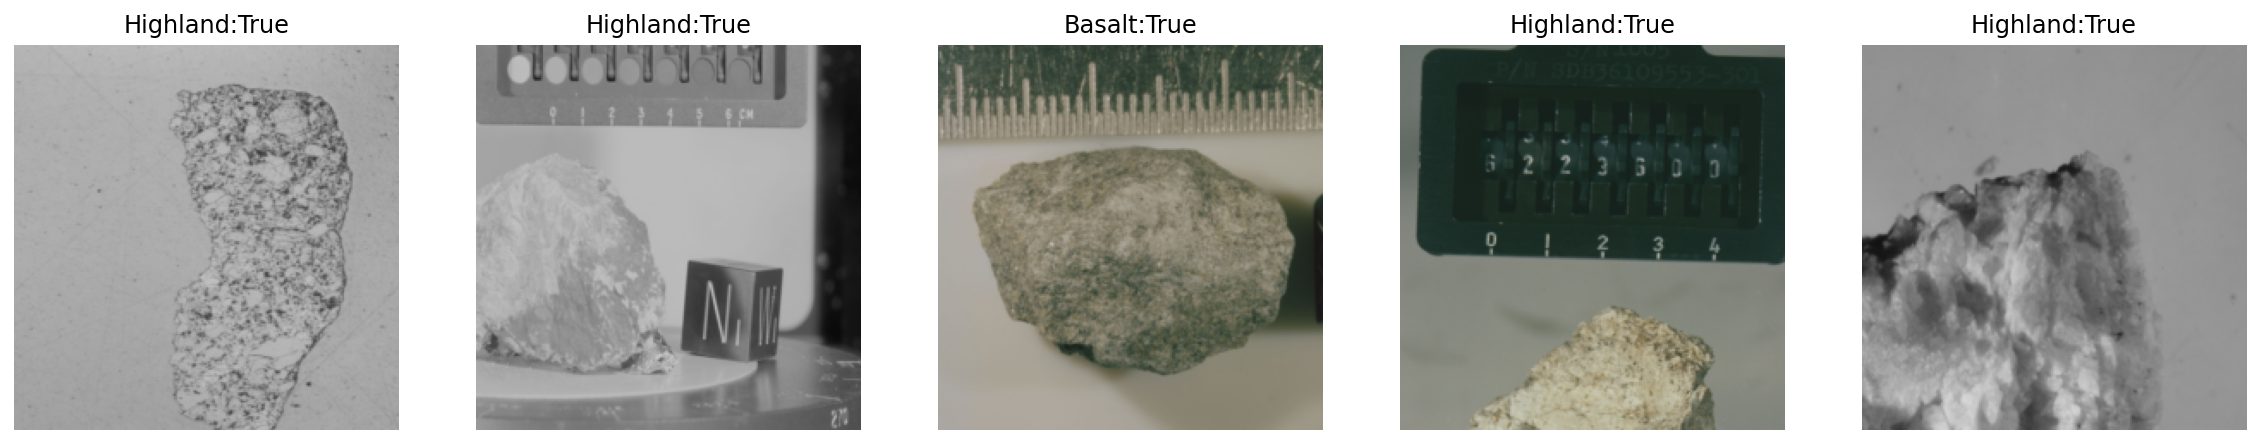

In [ ]:
#Testing the prediction accuracy
#Getting five random images and display them in a figure with their labels
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,10))

#Loading all of the classes from the training loader
classes=trainloader.dataset.classes

#Looping through the 5 randomly selected images
for ii in range(len(images)):

    # Predicting the class of each image
    image = to_pil(images[ii])
    index = predict_image(image)

    # Adding the class to the plot graph to display beneath the image
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)

#Showing the plot with the predicted labels beneath the images
plt.show()